In [1]:
from google.colab import drive
drive.mount('./drive')

!pip install unidecode
!pip install bpe
%cd /content/drive/MyDrive/NLU_assignment

Mounted at ./drive
     |████████████████████████████████| 245kB 33.9MB/s 
     |████████████████████████████████| 368kB 41.5MB/s 
     |████████████████████████████████| 21.5MB 42.9MB/s 
     |████████████████████████████████| 747kB 52.6MB/s 
/content/drive/MyDrive/NLU_assignment


# Import Libraries

In [2]:
from dataLoader.utils import load_file, save_file
from dataLoader.utils import get_poems_and_poets
from dataLoader.utils import get_training, separate
from sklearn.model_selection import train_test_split
from tokenization.bpe_tokenization import BPE_Tokenization
from dataLoader.generator import DataGenerator
from models.gru_encoder_decoder import get_encoder_decoder
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Loading and cleaning dataset

In [3]:
'''poem_list, poet_list  = get_poems_and_poets(path = "dataset/ganjoor.csv",
                                            cleaning = True,
                                            constrained_poets = ['حافظ','فردوسی'])

poem_list_train, poem_list_test, poet_list_train, poet_list_test = train_test_split(poem_list, poet_list, test_size=0.3, shuffle=False)

save_file(poem_list_train, 'dataset/poem_list_train.pickle')
save_file(poem_list_test, 'dataset/poem_list_test.pickle')
save_file(poet_list_train, 'dataset/poet_list_train.pickle')
save_file(poet_list_test, 'dataset/poet_list_test.pickle')'''

poem_list_train = load_file('dataset/poem_list_train.pickle')
poem_list_test = load_file('dataset/poem_list_test.pickle')
poet_list_train = load_file('dataset/poet_list_train.pickle')
poet_list_test = load_file('dataset/poet_list_test.pickle')

# Saving and loading Byte Pair Encoding Tokenizer

In [4]:
# creating and saving Byte Pair Encoding Tokenizer
'''bpet = BPE_Tokenization(poem_list_train+poem_list_test,
                            extra_tokens= ["__spm", "__epm", "__she", "__ehe1", "__ehe2", "__pad"],  
                            num_tokens = 30000,
                            ngram_max = 10)

save_file(bpet, 'tokenization/bpe_tokenization.pkl')'''

# loading Byte Pair Encoding Tokenizer
bpet = load_file('tokenization/bpe_tokenization.pkl')

In [5]:
example = ' '.join(poem_list_train[300])
print(bpet.to_index(example))

print(bpet.to_sentence(bpet.to_index(example)) )

[23391, 7380, 3061, 13985, 24172, 9435, 2871, 11386, 5338, 19649, 3997, 15208, 23710, 11360, 25684, 9435, 10888, 2326, 8910, 10677, 12432, 25884, 23010, 14606, 23010, 26618, 5404, 14212, 22556, 10436, 1126, 6177, 9096, 10620, 1126, 500, 25393, 9115, 1126, 7371, 9329, 5338, 26957, 24221, 23010, 11456, 24405, 24757, 10677, 457, 12432, 23010, 14606, 10888, 11386, 12028, 22556, 26615, 24007, 23010, 25298, 26746, 5882, 2871, 2530, 13091, 22610, 5454, 12028, 15055, 23386, 26618, 20394, 12028, 11562, 23010, 12028, 24070, 14761, 12028, 7185, 23386, 26052, 11781, 24737, 26334, 2871, 14606, 23010, 12432, 11386, 25684, 24394, 3107, 22826, 13985, 25684, 25365, 9659, 7673, 2795, 14723, 21095, 21769, 1126, 19849, 24361, 22627, 14480, 22726, 2312, 12393, 18669, 23837, 11048, 27216, 20639, 5287, 21189, 22744, 12028, 9435, 23386, 9056, 23010, 146, 22726, 1126, 7645, 2530, 2318, 11277, 23391, 25709, 5338, 1364, 2312, 563, 23839, 22726, 2454, 15208, 2312, 403, 12028, 7371, 1126, 551, 25684, 403, 18615, 2

# Preparing X_train and Y_traing according to number of hemistichs

In [6]:
temp_train = get_training(poem_list_train, bpet, max_num_he = 12)
temp_test = get_training(poem_list_test, bpet, max_num_he = 12)

#temp_train.sort(key=len) 
#temp_test.sort(key=len) 


X_train, Y_train = separate(temp_train, bpet)
X_test, Y_test = separate(temp_test, bpet)

# Removing Long length samples 

In [7]:
max_len = 120
def remove_long_(X, Y, max_len):
    X_temp = []
    Y_temp = []
    for (x,y) in zip(X, Y):
        if len(x) + len(y) <= max_len:
            X_temp.append(x)
            Y_temp.append(y)
    return X_temp, Y_temp

X_train, Y_train = remove_long_(X_train, Y_train, max_len)
X_test, Y_test = remove_long_(X_test, Y_test, max_len)

In [8]:
print(bpet.to_sentence(X_train[0]))
print(bpet.to_sentence(Y_train[0]))
print(bpet.to_sentence(X_test[0]))
print(bpet.to_sentence(Y_test[0]))

به نام خداوند جان و خرد __ehe1
کزین برتر اندیشه برنگذرد __ehe2
خوش آمد گل وز آن خوشتر نباشد __ehe1
که در دستت به جز ساغر نباشد __ehe2


# Transformer Model

In [ ]:
from models.transformer_encoder_decoder import Transformer_gru_encoder_decoder

model = Transformer_gru_encoder_decoder(len(bpet.bpe2idx), len(bpet.bpe2idx), num_heads=2, num_layers=12, d_model=64, pe_input=400, pe_target=50, training=True)
model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder_layer (Enco (None, None, 64)     5117760     encoder_input[0][0]              
__________________________________________________________________________________________________
transformer_decoder_layer (Deco ((None, None, 64), { 5318976     decoder_input[0][0]              
                                                                 transformer_encoder_layer[0][

# Attention based gru encoder-decoder

In [9]:
from models.gru_encoder_decoder import Gru_encoder_decoder

model = Gru_encoder_decoder(len(bpet.bpe2idx), len(bpet.bpe2idx),1024, use_att = True, dropout_rate = 0.3)
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics = ["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 1024)   27902976    encoder_input[0][0]              
__________________________________________________________________________________________________
gru_encoder_layer (Gru_encoder) ((None, None, 1024), 6297600     encoder_embedding[0][0]          
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
______________________________________________________________________________________________

# Loading model weights and optimizer weights

In [ ]:
model.load_weights('/content/drive/MyDrive/NLU_assignment/saved_model/attention_gru_encoder_decoder_model_weights5-hafez-ferdosi.h5')
#model._make_train_function()
with open('/content/drive/MyDrive/NLU_assignment/saved_model/attention_gru_encoder_decoder_optimizer.pkl', 'rb') as f:
    weight_values = pickle.load(f)
model.optimizer.set_weights(weight_values)

# Training model

In [ ]:
train_gen = DataGenerator(X_train,
                          Y_train,
                          bpet,
                          model,
                          save_path = "/content/drive/MyDrive/NLU_assignment/saved_model/attention_gru_encoder_decoder_",
                          batch_size = 64,
                          shuffle_data = True)

valid_gen = DataGenerator(X_test,
                          Y_test,
                          bpet,
                          None,
                          save_path = None,
                          batch_size = 64)

his = model.fit(train_gen,
          validation_data=valid_gen,
          epochs = 20)

Epoch 1/20
209/209 [==============================] - 205s 967ms/step - loss: 3.3031 - accuracy: 0.0671 - val_loss: 3.2105 - val_accuracy: 0.0901
Epoch 2/20
209/209 [==============================] - 212s 1s/step - loss: 2.4186 - accuracy: 0.1252 - val_loss: 2.9526 - val_accuracy: 0.0969
Epoch 3/20
209/209 [==============================] - 212s 1s/step - loss: 2.1131 - accuracy: 0.1521 - val_loss: 2.9155 - val_accuracy: 0.1002
Epoch 4/20
209/209 [==============================] - 211s 1s/step - loss: 1.8865 - accuracy: 0.1705 - val_loss: 2.8955 - val_accuracy: 0.1022
Epoch 5/20
209/209 [==============================] - 211s 1s/step - loss: 1.7461 - accuracy: 0.1900 - val_loss: 2.8955 - val_accuracy: 0.1050
Epoch 6/20
209/209 [==============================] - 211s 1s/step - loss: 1.5978 - accuracy: 0.2035 - val_loss: 2.9571 - val_accuracy: 0.1052
Epoch 7/20
209/209 [==============================] - 210s 1s/step - loss: 1.4816 - accuracy: 0.2211 - val_loss: 3.0041 - val_accuracy: 0.1

# Results of parameter tuning

In [ ]:
his1 = load_file('/content/drive/MyDrive/NLU_assignment/history/64.pickle')
his2 = load_file('/content/drive/MyDrive/NLU_assignment/history/128.pickle')
his3 = load_file('/content/drive/MyDrive/NLU_assignment/history/256.pickle')
his4 = load_file('/content/drive/MyDrive/NLU_assignment/history/512.pickle')
his5 = load_file('/content/drive/MyDrive/NLU_assignment/history/1024.pickle')

## Accuracy

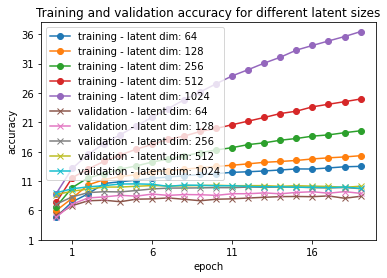

In [ ]:
len_ = len(his1['accuracy'])
plt.plot(np.array(range(len_)), [x*100 for x in his1['accuracy']], 'o-', label='training - latent dim: 64' )
plt.plot(np.array(range(len_)), [x*100 for x in his2['accuracy']], 'o-', label='training - latent dim: 128')
plt.plot(np.array(range(len_)), [x*100 for x in his3['accuracy']], 'o-', label='training - latent dim: 256')
plt.plot(np.array(range(len_)), [x*100 for x in his4['accuracy']], 'o-', label='training - latent dim: 512')
plt.plot(np.array(range(len_)), [x*100 for x in his5['accuracy']], 'o-', label='training - latent dim: 1024')

plt.plot(np.array(range(len_)), [x*100 for x in his1['val_accuracy']], 'x-', label='validation - latent dim: 64' )
plt.plot(np.array(range(len_)), [x*100 for x in his2['val_accuracy']], 'x-', label='validation - latent dim: 128')
plt.plot(np.array(range(len_)), [x*100 for x in his3['val_accuracy']], 'x-', label='validation - latent dim: 256')
plt.plot(np.array(range(len_)), [x*100 for x in his4['val_accuracy']], 'x-', label='validation - latent dim: 512')
plt.plot(np.array(range(len_)), [x*100 for x in his5['val_accuracy']], 'x-', label='validation - latent dim: 1024')

plt.xticks(range(1,21,5))
plt.yticks(range(1,38,5))

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and validation accuracy for different latent sizes')
plt.show()   

## Loss

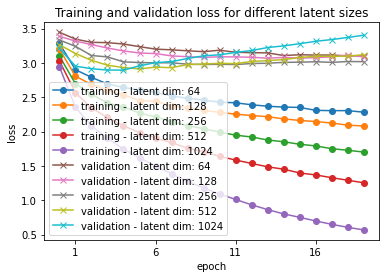

In [ ]:
plt.plot(np.array(range(len_)), his1['loss'], 'o-', label='training - latent dim: 64' )
plt.plot(np.array(range(len_)), his2['loss'], 'o-', label='training - latent dim: 128')
plt.plot(np.array(range(len_)), his3['loss'], 'o-', label='training - latent dim: 256')
plt.plot(np.array(range(len_)), his4['loss'], 'o-', label='training - latent dim: 512')
plt.plot(np.array(range(len_)), his5['loss'], 'o-', label='training - latent dim: 1024')

plt.plot(np.array(range(len_)), his1['val_loss'], 'x-', label='validation - latent dim: 64' )
plt.plot(np.array(range(len_)), his2['val_loss'], 'x-', label='validation - latent dim: 128')
plt.plot(np.array(range(len_)), his3['val_loss'], 'x-', label='validation - latent dim: 256')
plt.plot(np.array(range(len_)), his4['val_loss'], 'x-', label='validation - latent dim: 512')
plt.plot(np.array(range(len_)), his5['val_loss'], 'x-', label='validation - latent dim: 1024')

plt.xticks(range(1,21,5))

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Training and validation loss for different latent sizes')
plt.show()   